In [1]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
import os
import sys
project_basedir = '..'
sys.path.append(project_basedir)
from config import conf
import json
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('ggplot')
%matplotlib inline

In [2]:
validate_dirs = os.listdir(conf.validate_dir)
validate_dirs = [i for i in validate_dirs if i != '_blank']
validate_dirs = sorted(validate_dirs)
validate_dirs = [os.path.join(conf.validate_dir,i) for i in validate_dirs]

In [3]:
def add_score(onedic,key,point):
    onedic.setdefault(key,0)
    onedic[key] += point
def cal_points(gameplays):
    point_dic = {}
    for onegame in gameplays:
        if onegame[-3:] != 'cbf':
            continue
        winner = onegame.split('_')[-1].split('.')[0]
        player1 = onegame.split('_')[-2].split('-')[0]
        player2 = onegame.split('_')[-2].split('-')[1]
        assert(winner in ['w','b','peace'])
        if winner == 'w':
            add_score(point_dic,player1,1)
            add_score(point_dic,player2,0)
        elif winner == 'b':
            add_score(point_dic,player1,0)
            add_score(point_dic,player2,1)
        elif winner == 'peace':
            add_score(point_dic,player1,0.5)
            add_score(point_dic,player2,0.5)
            add_score(point_dic,'peace',1)
        else:
            raise
    return point_dic

In [4]:
game_numbers = [0]
game_numbers_identity = [0]
elu_points = [0]
validate_games = [0]
win_rate = [0]
dates = ['start']
peace_rates = [0]
delta_elo = [0]
for one_dir in validate_dirs:
    one_date = one_dir.split('/')[-1]
    gameplays = os.listdir(one_dir)
    pointcdic = cal_points(gameplays)
    game_num = len(gameplays)
    
    try:
        gn = len(os.listdir(os.path.join(conf.history_selfplay_dir,one_date.replace('_noup',''))))
    except:
        gn = 0
    if game_num == 0:
        continue
        
    old_score = pointcdic.get('oldnet',0) / game_num
    peace_rate = pointcdic.get('peace',0) / game_num
    
    if old_score == 0:
        continue
        
    game_numbers.append(game_numbers[-1] + gn)
    game_numbers_identity.append(gn)
    
    
    elo = np.log10(1 / old_score - 1) * 400
    if one_date >= '2018-08-27_22-13-25' and one_date < '2018-09-16_17-00-24' and elo < 0:
        elo = 0
    #elif one_date >= '2018-09-16_17-00-24' and elo < -100:
    #    elo = 0
    elu_points.append(elu_points[-1] + elo)
    validate_games.append(len(gameplays))
    win_rate.append(1 - old_score)
    dates.append(one_date)
    peace_rates.append(peace_rate)
    delta_elo.append(elo)

Text(0, 0.5, 'Elo')

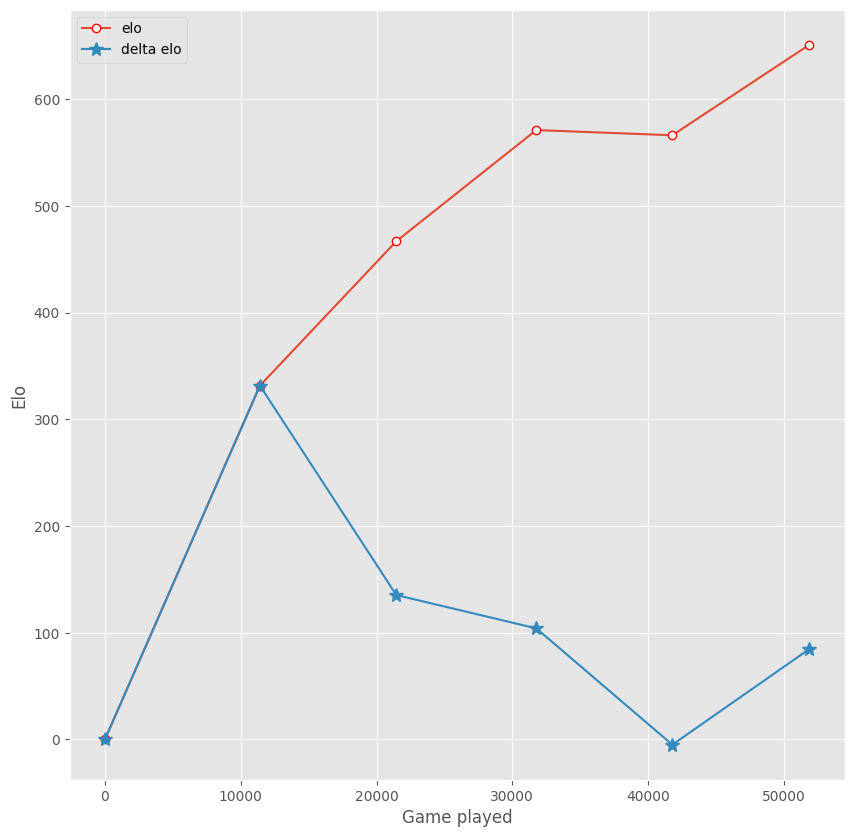

In [6]:
plt.figure(figsize=(10,10))
plt.plot(game_numbers,elu_points,marker='o',mec='r',mfc='w',label='elo')
plt.plot(game_numbers,delta_elo,marker='*',ms=10,label='delta elo')
plt.legend()
plt.xlabel("Game played")
plt.ylabel("Elo")

In [7]:
pd.DataFrame({
    'dates':dates,
    'game_numbers':game_numbers,
    'game_numbers_identity':game_numbers_identity,
    'elu_points':elu_points,
    'validate_games':validate_games,
    'win_rate':win_rate,
    'peace_rates':peace_rates,
    'delta_elo':delta_elo,
    '上位情况':[('pending' if i is None else "上位") for i in delta_elo]
})[-10:]

,dates,game_numbers,game_numbers_identity,elu_points,validate_games,win_rate,peace_rates,delta_elo,上位情况
0,start,0,0,0.000000,0,0.000000,0.000000,0.000000,上位
1,2022-11-15_23-34-37_noup,11416,11416,331.483050,209,0.870813,0.162679,331.483050,上位
2,2022-11-17_09-00-12_noup,21459,10043,466.794271,213,0.685446,0.281690,135.311221,上位
3,2022-11-18_11-00-12_noup,31765,10306,570.936569,213,0.645540,0.164319,104.142299,上位
4,2022-11-19_08-00-12_noup,41782,10017,566.042787,213,0.492958,0.262911,-4.893783,上位
5,2022-11-20_04-00-12_noup,51877,10095,650.878352,213,0.619718,0.262911,84.835565,上位


In [8]:
!ls -l ../data/distributed/ | wc -l 

3059


In [9]:
!ls -l ../data/distributed/ | grep peace | wc -l

18


In [10]:
!ls -l ../data/distributed/ | grep '_w'| wc -l 

1639


In [11]:
!ls -l ../data/distributed/ | grep '_b'| wc -l 

1401


In [12]:
! date

2022年 11月 20日 星期日 11:31:51 CST


In [29]:
!nvidia-smi

Fri Nov 18 11:34:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.56.06    Driver Version: 520.56.06    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0  On |                  Off |
| 30%   46C    P2   115W / 450W |  22721MiB / 24564MiB |     35%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------